In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression as LR
import warnings
warnings.filterwarnings('ignore')

class Decline_Generator():
    '''This class creates synthetic gas production data with dropouts, low point, high points and noise.
    Return data is a pandas dataframe with columns "date" and "production'''
    def __init__(self, n = 365*2, drops = (0,0), 
    noise = 0, highpoints = (0,0), lowpoints = (0,0), decline_rate = .996):
        dates = pd.date_range(start = '2018-01-01', end = '2019-01-01', periods = n)
        
        x = 100
        production = []
        
        for _ in range(n):
            production.append(x)
            x*=decline_rate
            
        production = np.array(production) + np.random.random(size = n)*noise

        for i in range(highpoints[0]):
            index = np.random.randint(n)
            production[index] += highpoints[1]

        for i in range(lowpoints[0]):
            index = np.random.randint(n)
            production[index] -= lowpoints[1]

        for i in range(drops[0]):
            start = np.random.randint(n-drops[1])
            production[start:start+drops[1]] = 0
            
        production += np.random.random(size = n)*noise
        production[production <=1] = 1.1
        
#         data.loc[data['production']<=1, 'production'] = 1.1
        data = pd.DataFrame({'date':dates,'production':production})
        
        
        self.data = data    

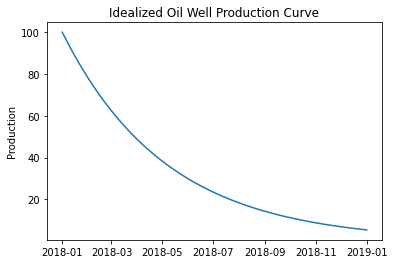

In [2]:
data = Decline_Generator().data

plt.plot(data['date'],data['production'])
plt.ylabel('Production')   
plt.title('Idealized Oil Well Production Curve');

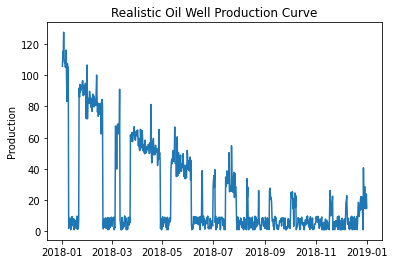

In [3]:
data = Decline_Generator(drops = (20,25), noise = 10, highpoints = (45,20), lowpoints = (25,20)).data

plt.plot(data['date'],data['production'])
plt.ylabel('Production')   
plt.title('Realistic Oil Well Production Curve');

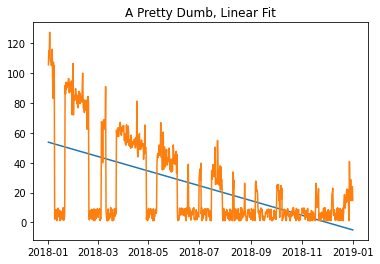

In [4]:
from sklearn.linear_model import LinearRegression as LR
linear = LR().fit(data[['date']].astype(int),data['production'] )
plt.plot(data['date'], linear.predict(data[['date']].astype(int)))
plt.plot(data['date'], data['production'])
plt.title('A Pretty Dumb, Linear Fit');

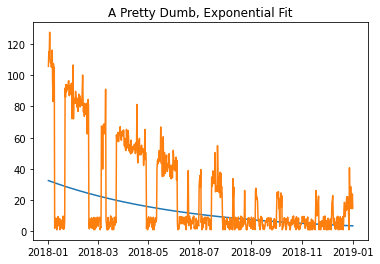

In [5]:
exp_model = LR().fit(data[['date']].astype(int),np.log(data['production'] ))
plt.plot(data['date'], np.exp(exp_model.predict(data[['date']].astype(int))))
plt.plot(data['date'], data['production'])
plt.title('A Pretty Dumb, Exponential Fit');

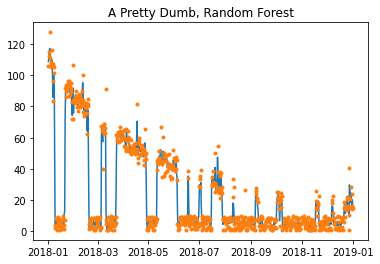

In [6]:
from sklearn.ensemble import RandomForestRegressor as RFR
rfr = RFR(n_estimators = 10, max_depth=10).fit(data[['date']].astype(int), data['production'] )
plt.plot(data['date'], rfr.predict(data[['date']].astype(int)))
plt.plot(data['date'], data['production'], marker = '.', linestyle = '')
plt.title('A Pretty Dumb, Random Forest');

Index(['production', 'delta-3', 'delta-2', 'delta-1', 'delta1', 'delta2',
       'delta3', 'epsilon'],
      dtype='object')


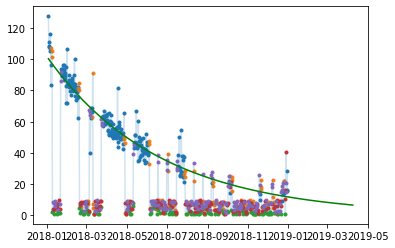

In [7]:
X = data.copy()

X['production'] = np.log(X['production'])

'''Add Delta Columns for differences''' 
for i in [-3,-2,-1,1,2,3]:
    X['delta{}'.format(i)] = X.production.diff(i)

X['days_ago'] = (X['date'].max()-X['date']).dt.days
X['epsilon'] = X['days_ago']/X['production']

X = X.drop(['date','days_ago'], axis = 1).reset_index()
X = X.dropna()
indices = X['index']
X.drop('index',axis = 1, inplace = True)

print(X.columns)

X = PCA(n_components = int(len(X.columns)/1.5), whiten = True).fit_transform(X)
labels = KMeans(n_clusters =6).fit(X).predict(X)
data['labels'] = -1
data['labels'].iloc[indices] = labels
data = data[data['labels']>=0]

majority_class = data.groupby('labels').count().sort_values('date').index[-1]
majority = data[data['labels']==majority_class].drop('labels', axis = 1)
majority['log_production'] = np.log(majority['production'])

model = LR().fit(majority['date'].values.reshape(-1,1), majority['log_production'])
first_pass_predictions = model.predict(majority['date'].values.astype(float).reshape(-1,1))
first_pass_residuals = first_pass_predictions - majority['log_production']

mean, std = first_pass_residuals.mean(), first_pass_residuals.std()    
filter = (first_pass_residuals > mean-2*std)&(first_pass_residuals<mean+2*std)

filtered_majority = majority[filter]
filtered_model = LR().fit(filtered_majority['date'].values.reshape(-1,1), filtered_majority['log_production'])
prediction_dates = pd.date_range(start = majority.date.min(), end = majority.date.max() + pd.DateOffset(days = 100))
predictions = filtered_model.predict(prediction_dates.values.astype(float).reshape(-1,1))
predictions = np.exp(predictions)

plt.plot(prediction_dates, predictions, color = 'green')
plt.plot(data.set_index('date')['production'], alpha = .2)

for label in data['labels'].unique():
    l = data[data['labels'] == label]
    plt.scatter(l['date'], l['production'], marker = '.')
